## Regressão Linear - Passageiros Pagos x Assentos Ofertados

In [21]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from openpyxl import load_workbook
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error, mean_squared_error, classification_report
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

np.set_printoptions(suppress=True)

In [3]:
file_name = './data/database.xlsx'
dataframe = pd.read_excel( file_name )

## Método para obter dados agregados de determinado Aeroporto

In [4]:
def get_airport_data(airport):
    airport_data = dataframe[ (dataframe['AEROPORTO_ORIGEM_SIGLA'] == airport) | (dataframe['AEROPORTO_DESTINO_SIGLA'] == airport) ]
    return airport_data.groupby(['ANO', 'MES'], as_index=False).sum()

In [5]:
INDEX_COLUMNS = ['ANO', 'MES', 'PAX_PAGOS']
WANTED_COLUMNS = ['ASSENTOS']

## Treinamento de dados

In [27]:
def airport_pax_prediction_monthly(airports, jobs=1):
    airport_data = {}
    results = []
    algorithms = [DecisionTreeRegressor, RandomForestRegressor, ExtraTreeRegressor]
    months = np.arange(1, 13)
    
    for icao_code in airports:
        airport_data[icao_code] = get_airport_data( icao_code )
        airport_data[icao_code] = airport_data[icao_code][ airport_data[icao_code]['ANO'] < 2018 ]
    
    for icao_code in airports:
        for i in range(0, jobs):
            
            for month in months:
                airport_month_data = airport_data[icao_code][ airport_data[icao_code]['MES'] == month ]
                X_Train, X_Test, y_train, y_test = train_test_split( airport_month_data[INDEX_COLUMNS], airport_month_data[WANTED_COLUMNS], test_size=0.2 )
                
                if( X_Train.shape[0] == 0 or X_Train.shape[1] == 0 or y_train.shape[0] == 0 or y_train.shape[1] == 0):
                   continue
                
                for alg in algorithms:
                    rg = alg()
                    rg.fit( X_Train, y_train.values.ravel() )

                    y_pred = rg.predict( X_Test )
                    
                    r2score = r2_score(y_test, y_pred)
                    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                    importances = rg.feature_importances_
                    
                    results.append({
                        'Aeroporto': icao_code,
                        'Mes': month,
                        'R2 SCORE': r2score,
                        'RMSE': rmse,
                        'FI_ANO': importances[0],
                        'FI_PAX_PAGOS': importances[2],
                        'Algoritmo': alg.__name__
                    })
                    
                    print( "[%s (%d) / %s ] \tR2 SCORE : %.4f [%d/%d] " % (icao_code, month, alg.__name__, r2score, i, jobs) )
                
                print("\n")                
    
    book = load_workbook('results.xlsx')
    sheet_name = 'PaxMonthPredict%i' % int(time.time())
    
    writer = pd.ExcelWriter('results.xlsx', engine='openpyxl')
    writer.book = book
    
    pd.DataFrame(results).to_excel(writer, sheet_name, columns=["Aeroporto", "Mes", "R2 SCORE", "RMSE", "FI_ANO", "FI_PAX_PAGOS", "Algoritmo"])
    
    writer.save()
    writer.close()
    
    #return results

#airport_pax_prediction_monthly(['SBGR', 'SBGL', 'SBBR', 'SBSV', 'SBFZ', 'SBPA', 'SBJE'], jobs=1)

In [29]:
def airport_pax_prediction_general(airports, jobs=1):
    airport_data = {}
    results = []
    algorithms = [DecisionTreeRegressor, RandomForestRegressor, ExtraTreeRegressor]
        
    for icao_code in airports:
        airport_data[icao_code] = get_airport_data( icao_code )
        airport_data[icao_code] = airport_data[icao_code][ airport_data[icao_code]['ANO'] < 2018 ]
    
    for icao_code in airports:
        for i in range(0, jobs):
            X_Train, X_Test, y_train, y_test = train_test_split( airport_data[icao_code][INDEX_COLUMNS], airport_data[icao_code][WANTED_COLUMNS], test_size=0.2 )
            
            if( X_Train.shape[0] == 0 or X_Train.shape[1] == 0 or y_train.shape[0] == 0 or y_train.shape[1] == 0):
                continue
            
            for alg in algorithms:
                rg = alg()
                rg.fit( X_Train, y_train.values.ravel() )

                y_pred = rg.predict( X_Test )
                    
                r2score = r2_score(y_test, y_pred)
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                importances = rg.feature_importances_
                    
                results.append({
                    'Aeroporto': icao_code,
                    'R2 SCORE': r2score,
                    'RMSE': rmse,
                    'FI_ANO': importances[0],
                    'FI_MES': importances[1],
                    'FI_PAX_PAGOS': importances[2],
                    'Algoritmo': alg.__name__
                })

                print( "[%s / %s ] \tR2 SCORE : %.4f - RMSE : %.4f [%d/%d] " % (icao_code, alg.__name__, r2score, rmse, i, jobs) )
    
    book = load_workbook('results.xlsx')
    sheet_name = 'PaxGeneralPredict%i' % int(time.time())
    
    writer = pd.ExcelWriter('results.xlsx', engine='openpyxl')
    writer.book = book
    
    pd.DataFrame(results).to_excel(writer, sheet_name, columns=["Aeroporto", "R2 SCORE", "RMSE", "FI_ANO", "FI_MES", "FI_PAX_PAGOS", "Algoritmo"])
    
    writer.save()
    writer.close()
    
    #return results

airport_pax_prediction_general(['SBGR', 'SBGL', 'SBBR', 'SBSV', 'SBFZ', 'SBPA', 'SBJE'], jobs=100)

[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9822 - RMSE : 126063.3482 [0/100] 
[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9877 - RMSE : 104521.4667 [0/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9869 - RMSE : 107939.9009 [0/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9770 - RMSE : 133352.8156 [1/100] 
[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9858 - RMSE : 104782.0105 [1/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9819 - RMSE : 118205.9575 [1/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9857 - RMSE : 115028.0999 [2/100] 
[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9891 - RMSE : 100373.5506 [2/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9835 - RMSE : 123605.1709 [2/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9839 - RMSE : 124226.9661 [3/100] 
[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9918 - RMSE : 88705.0373 [3/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9843 - RMSE : 122547.0035 [3/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE

[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9887 - RMSE : 103447.1083 [34/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9796 - RMSE : 139166.3036 [34/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9899 - RMSE : 95645.7424 [35/100] 
[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9903 - RMSE : 93848.8452 [35/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9882 - RMSE : 103218.2471 [35/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9766 - RMSE : 138998.5811 [36/100] 
[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9837 - RMSE : 116221.7213 [36/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9809 - RMSE : 125782.0887 [36/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9840 - RMSE : 125685.7112 [37/100] 
[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9927 - RMSE : 84695.7589 [37/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9854 - RMSE : 119992.7357 [37/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9841 - RMSE : 120571.9437 [38/100] 
[SBGR / RandomForestRegressor ]

[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9886 - RMSE : 101961.8454 [70/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9854 - RMSE : 115245.8953 [70/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9825 - RMSE : 115859.0038 [71/100] 
[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9893 - RMSE : 90647.5231 [71/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9846 - RMSE : 108935.4495 [71/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9843 - RMSE : 126388.3339 [72/100] 
[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9911 - RMSE : 94808.6715 [72/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9820 - RMSE : 135234.0141 [72/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9916 - RMSE : 97742.9561 [73/100] 
[SBGR / RandomForestRegressor ] 	R2 SCORE : 0.9930 - RMSE : 89526.9699 [73/100] 
[SBGR / ExtraTreeRegressor ] 	R2 SCORE : 0.9895 - RMSE : 109572.4256 [73/100] 
[SBGR / DecisionTreeRegressor ] 	R2 SCORE : 0.9853 - RMSE : 113354.9501 [74/100] 
[SBGR / RandomForestRegressor ] 

[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9773 - RMSE : 69750.3158 [7/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9663 - RMSE : 85082.2902 [7/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9729 - RMSE : 75788.6922 [8/100] 
[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9814 - RMSE : 62760.4901 [8/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9769 - RMSE : 70006.8520 [8/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9766 - RMSE : 68108.6198 [9/100] 
[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9730 - RMSE : 73054.0180 [9/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9795 - RMSE : 63688.2929 [9/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9302 - RMSE : 111579.4187 [10/100] 
[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9657 - RMSE : 78184.3088 [10/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9617 - RMSE : 82657.8304 [10/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9111 - RMSE : 132137.9904 [11/100] 
[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.

[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9706 - RMSE : 70210.6243 [43/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9457 - RMSE : 95433.2591 [43/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9297 - RMSE : 116144.6866 [44/100] 
[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9631 - RMSE : 84109.1936 [44/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9266 - RMSE : 118704.8568 [44/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9731 - RMSE : 75905.6705 [45/100] 
[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9831 - RMSE : 60269.0496 [45/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9742 - RMSE : 74392.1941 [45/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9512 - RMSE : 96975.1795 [46/100] 
[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9717 - RMSE : 73881.8181 [46/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9350 - RMSE : 111899.9895 [46/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9624 - RMSE : 87941.5219 [47/100] 
[SBGL / RandomForestRegressor ] 	R2 S

[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9641 - RMSE : 81116.0642 [85/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9403 - RMSE : 110316.7676 [86/100] 
[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9627 - RMSE : 87244.8789 [86/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9606 - RMSE : 89677.7236 [86/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9807 - RMSE : 63178.4435 [87/100] 
[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9884 - RMSE : 49090.5993 [87/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9716 - RMSE : 76668.3939 [87/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9773 - RMSE : 67220.6123 [88/100] 
[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9752 - RMSE : 70207.2975 [88/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE : 0.9663 - RMSE : 81932.5182 [88/100] 
[SBGL / DecisionTreeRegressor ] 	R2 SCORE : 0.9611 - RMSE : 86196.9459 [89/100] 
[SBGL / RandomForestRegressor ] 	R2 SCORE : 0.9778 - RMSE : 65068.9407 [89/100] 
[SBGL / ExtraTreeRegressor ] 	R2 SCORE 

[SBBR / ExtraTreeRegressor ] 	R2 SCORE : 0.9629 - RMSE : 84541.2408 [28/100] 
[SBBR / DecisionTreeRegressor ] 	R2 SCORE : 0.9766 - RMSE : 70515.5130 [29/100] 
[SBBR / RandomForestRegressor ] 	R2 SCORE : 0.9808 - RMSE : 63926.5774 [29/100] 
[SBBR / ExtraTreeRegressor ] 	R2 SCORE : 0.9711 - RMSE : 78409.7425 [29/100] 
[SBBR / DecisionTreeRegressor ] 	R2 SCORE : 0.9747 - RMSE : 70968.6801 [30/100] 
[SBBR / RandomForestRegressor ] 	R2 SCORE : 0.9792 - RMSE : 64359.5094 [30/100] 
[SBBR / ExtraTreeRegressor ] 	R2 SCORE : 0.9656 - RMSE : 82738.7229 [30/100] 
[SBBR / DecisionTreeRegressor ] 	R2 SCORE : 0.9769 - RMSE : 65895.0688 [31/100] 
[SBBR / RandomForestRegressor ] 	R2 SCORE : 0.9839 - RMSE : 55044.1430 [31/100] 
[SBBR / ExtraTreeRegressor ] 	R2 SCORE : 0.9676 - RMSE : 78079.8876 [31/100] 
[SBBR / DecisionTreeRegressor ] 	R2 SCORE : 0.9597 - RMSE : 86455.5250 [32/100] 
[SBBR / RandomForestRegressor ] 	R2 SCORE : 0.9749 - RMSE : 68180.1393 [32/100] 
[SBBR / ExtraTreeRegressor ] 	R2 SCORE :

[SBBR / RandomForestRegressor ] 	R2 SCORE : 0.9817 - RMSE : 60721.2458 [64/100] 
[SBBR / ExtraTreeRegressor ] 	R2 SCORE : 0.9731 - RMSE : 73691.1532 [64/100] 
[SBBR / DecisionTreeRegressor ] 	R2 SCORE : 0.9629 - RMSE : 88272.3348 [65/100] 
[SBBR / RandomForestRegressor ] 	R2 SCORE : 0.9783 - RMSE : 67518.7198 [65/100] 
[SBBR / ExtraTreeRegressor ] 	R2 SCORE : 0.9626 - RMSE : 88696.8392 [65/100] 
[SBBR / DecisionTreeRegressor ] 	R2 SCORE : 0.9406 - RMSE : 111405.1837 [66/100] 
[SBBR / RandomForestRegressor ] 	R2 SCORE : 0.9649 - RMSE : 85620.0379 [66/100] 
[SBBR / ExtraTreeRegressor ] 	R2 SCORE : 0.9521 - RMSE : 100023.4066 [66/100] 
[SBBR / DecisionTreeRegressor ] 	R2 SCORE : 0.9695 - RMSE : 79658.5615 [67/100] 
[SBBR / RandomForestRegressor ] 	R2 SCORE : 0.9826 - RMSE : 60238.4814 [67/100] 
[SBBR / ExtraTreeRegressor ] 	R2 SCORE : 0.9732 - RMSE : 74741.0847 [67/100] 
[SBBR / DecisionTreeRegressor ] 	R2 SCORE : 0.9741 - RMSE : 70623.1915 [68/100] 
[SBBR / RandomForestRegressor ] 	R2 SC

[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9514 - RMSE : 45482.8032 [8/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.8938 - RMSE : 69613.4351 [9/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9413 - RMSE : 51733.2721 [9/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9400 - RMSE : 52337.1080 [9/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.9213 - RMSE : 68278.0272 [10/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9592 - RMSE : 49139.0843 [10/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9485 - RMSE : 55221.0916 [10/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.9263 - RMSE : 61509.0593 [11/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9691 - RMSE : 39788.2485 [11/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9463 - RMSE : 52486.4734 [11/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.9448 - RMSE : 53776.1642 [12/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9637 - RMSE : 43608.8477 [12/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9

[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.9193 - RMSE : 66214.2592 [45/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9329 - RMSE : 60397.4411 [45/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9060 - RMSE : 71462.1825 [45/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.9001 - RMSE : 71231.5235 [46/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9436 - RMSE : 53515.2182 [46/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9131 - RMSE : 66435.4549 [46/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.8942 - RMSE : 69077.8909 [47/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9546 - RMSE : 45234.7041 [47/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.8305 - RMSE : 87443.7898 [47/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.9402 - RMSE : 53134.3070 [48/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9729 - RMSE : 35776.7223 [48/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9503 - RMSE : 48424.3912 [48/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCOR

[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.8959 - RMSE : 68321.9861 [82/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9536 - RMSE : 45599.3952 [82/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9168 - RMSE : 61063.2814 [82/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.9506 - RMSE : 56237.3201 [83/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9702 - RMSE : 43704.7436 [83/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9388 - RMSE : 62599.0206 [83/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.9836 - RMSE : 32084.6398 [84/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9808 - RMSE : 34653.6170 [84/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9667 - RMSE : 45642.6014 [84/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCORE : 0.9532 - RMSE : 51458.4666 [85/100] 
[SBSV / RandomForestRegressor ] 	R2 SCORE : 0.9640 - RMSE : 45149.8871 [85/100] 
[SBSV / ExtraTreeRegressor ] 	R2 SCORE : 0.9180 - RMSE : 68099.5021 [85/100] 
[SBSV / DecisionTreeRegressor ] 	R2 SCOR

[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.9592 - RMSE : 34338.3418 [17/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9599 - RMSE : 33791.6399 [18/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9833 - RMSE : 21796.8517 [18/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.9704 - RMSE : 29010.2474 [18/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9687 - RMSE : 27877.6581 [19/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9751 - RMSE : 24866.8221 [19/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.9259 - RMSE : 42880.2103 [19/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9548 - RMSE : 37132.0459 [20/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9755 - RMSE : 27331.0603 [20/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.9675 - RMSE : 31462.0383 [20/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9605 - RMSE : 36024.6166 [21/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9634 - RMSE : 34687.2848 [21/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE :

[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9560 - RMSE : 37840.6581 [52/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9670 - RMSE : 32763.5140 [52/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.9609 - RMSE : 35676.4658 [52/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9772 - RMSE : 24274.8417 [53/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9843 - RMSE : 20183.2753 [53/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.9763 - RMSE : 24771.9882 [53/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9755 - RMSE : 28400.9755 [54/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9717 - RMSE : 30537.2350 [54/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.9497 - RMSE : 40702.0607 [54/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9694 - RMSE : 33911.4960 [55/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9822 - RMSE : 25859.4621 [55/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.9654 - RMSE : 36062.1514 [55/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCOR

[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9678 - RMSE : 31351.3192 [88/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.8892 - RMSE : 58156.0907 [88/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9603 - RMSE : 34205.5907 [89/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9671 - RMSE : 31137.0834 [89/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.9263 - RMSE : 46639.6877 [89/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9593 - RMSE : 37534.3272 [90/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9663 - RMSE : 34157.5247 [90/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.9684 - RMSE : 33067.3656 [90/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9481 - RMSE : 37456.1895 [91/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCORE : 0.9666 - RMSE : 30038.7770 [91/100] 
[SBFZ / ExtraTreeRegressor ] 	R2 SCORE : 0.9434 - RMSE : 39099.1359 [91/100] 
[SBFZ / DecisionTreeRegressor ] 	R2 SCORE : 0.9698 - RMSE : 30938.9952 [92/100] 
[SBFZ / RandomForestRegressor ] 	R2 SCOR

[SBPA / ExtraTreeRegressor ] 	R2 SCORE : 0.9542 - RMSE : 45562.3647 [31/100] 
[SBPA / DecisionTreeRegressor ] 	R2 SCORE : 0.9491 - RMSE : 45511.7378 [32/100] 
[SBPA / RandomForestRegressor ] 	R2 SCORE : 0.9775 - RMSE : 30269.7325 [32/100] 
[SBPA / ExtraTreeRegressor ] 	R2 SCORE : 0.9781 - RMSE : 29821.4076 [32/100] 
[SBPA / DecisionTreeRegressor ] 	R2 SCORE : 0.9451 - RMSE : 51728.5637 [33/100] 
[SBPA / RandomForestRegressor ] 	R2 SCORE : 0.9738 - RMSE : 35750.7640 [33/100] 
[SBPA / ExtraTreeRegressor ] 	R2 SCORE : 0.9719 - RMSE : 36977.8949 [33/100] 
[SBPA / DecisionTreeRegressor ] 	R2 SCORE : 0.9771 - RMSE : 29992.1863 [34/100] 
[SBPA / RandomForestRegressor ] 	R2 SCORE : 0.9802 - RMSE : 27886.9110 [34/100] 
[SBPA / ExtraTreeRegressor ] 	R2 SCORE : 0.9711 - RMSE : 33704.1866 [34/100] 
[SBPA / DecisionTreeRegressor ] 	R2 SCORE : 0.9583 - RMSE : 38921.7795 [35/100] 
[SBPA / RandomForestRegressor ] 	R2 SCORE : 0.9776 - RMSE : 28489.7055 [35/100] 
[SBPA / ExtraTreeRegressor ] 	R2 SCORE :

[SBPA / DecisionTreeRegressor ] 	R2 SCORE : 0.9560 - RMSE : 42685.2486 [67/100] 
[SBPA / RandomForestRegressor ] 	R2 SCORE : 0.9760 - RMSE : 31519.6868 [67/100] 
[SBPA / ExtraTreeRegressor ] 	R2 SCORE : 0.9583 - RMSE : 41565.6967 [67/100] 
[SBPA / DecisionTreeRegressor ] 	R2 SCORE : 0.9310 - RMSE : 52503.8880 [68/100] 
[SBPA / RandomForestRegressor ] 	R2 SCORE : 0.9760 - RMSE : 30945.9268 [68/100] 
[SBPA / ExtraTreeRegressor ] 	R2 SCORE : 0.9508 - RMSE : 44336.0437 [68/100] 
[SBPA / DecisionTreeRegressor ] 	R2 SCORE : 0.9580 - RMSE : 43785.9228 [69/100] 
[SBPA / RandomForestRegressor ] 	R2 SCORE : 0.9800 - RMSE : 30247.1522 [69/100] 
[SBPA / ExtraTreeRegressor ] 	R2 SCORE : 0.9581 - RMSE : 43777.1539 [69/100] 
[SBPA / DecisionTreeRegressor ] 	R2 SCORE : 0.9713 - RMSE : 36458.7753 [70/100] 
[SBPA / RandomForestRegressor ] 	R2 SCORE : 0.9767 - RMSE : 32803.2596 [70/100] 
[SBPA / ExtraTreeRegressor ] 	R2 SCORE : 0.9719 - RMSE : 36035.8679 [70/100] 
[SBPA / DecisionTreeRegressor ] 	R2 SCOR

[SBJE / RandomForestRegressor ] 	R2 SCORE : -23.9104 - RMSE : 4711.5382 [3/100] 
[SBJE / ExtraTreeRegressor ] 	R2 SCORE : -19.1406 - RMSE : 4236.5122 [3/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : 0.7290 - RMSE : 1720.1308 [4/100] 
[SBJE / RandomForestRegressor ] 	R2 SCORE : 0.0452 - RMSE : 3228.3831 [4/100] 
[SBJE / ExtraTreeRegressor ] 	R2 SCORE : 0.8181 - RMSE : 1409.1820 [4/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : -19.1406 - RMSE : 4236.5122 [5/100] 
[SBJE / RandomForestRegressor ] 	R2 SCORE : -22.0900 - RMSE : 4536.1140 [5/100] 
[SBJE / ExtraTreeRegressor ] 	R2 SCORE : -19.1406 - RMSE : 4236.5122 [5/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : 0.7290 - RMSE : 1720.1308 [6/100] 
[SBJE / RandomForestRegressor ] 	R2 SCORE : 0.5448 - RMSE : 2229.1766 [6/100] 
[SBJE / ExtraTreeRegressor ] 	R2 SCORE : 0.8181 - RMSE : 1409.1820 [6/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : -25.3015 - RMSE : 2297.5683 [7/100] 
[SBJE / RandomForestRegressor ] 	R2 SCORE : -1.4063 

[SBJE / ExtraTreeRegressor ] 	R2 SCORE : 0.6921 - RMSE : 2798.3056 [45/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : -0.4622 - RMSE : 2459.5516 [46/100] 
[SBJE / RandomForestRegressor ] 	R2 SCORE : -0.7449 - RMSE : 2686.7985 [46/100] 
[SBJE / ExtraTreeRegressor ] 	R2 SCORE : -0.5040 - RMSE : 2494.4522 [46/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : -0.8070 - RMSE : 634.4762 [47/100] 
[SBJE / RandomForestRegressor ] 	R2 SCORE : -1.8379 - RMSE : 795.1365 [47/100] 
[SBJE / ExtraTreeRegressor ] 	R2 SCORE : -21.7864 - RMSE : 2253.0979 [47/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : -14717.4618 - RMSE : 2911.6720 [48/100] 
[SBJE / RandomForestRegressor ] 	R2 SCORE : -4135.1530 - RMSE : 1543.5103 [48/100] 
[SBJE / ExtraTreeRegressor ] 	R2 SCORE : -14717.4618 - RMSE : 2911.6720 [48/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : -1.0478 - RMSE : 2910.6494 [49/100] 
[SBJE / RandomForestRegressor ] 	R2 SCORE : -0.5800 - RMSE : 2556.7355 [49/100] 
[SBJE / ExtraTreeRegressor ] 	R

[SBJE / RandomForestRegressor ] 	R2 SCORE : -0.2256 - RMSE : 26.5699 [87/100] 
[SBJE / ExtraTreeRegressor ] 	R2 SCORE : -29070.2500 - RMSE : 4092.0704 [87/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : -0.0654 - RMSE : 2618.6962 [88/100] 
[SBJE / RandomForestRegressor ] 	R2 SCORE : -0.0370 - RMSE : 2583.5360 [88/100] 
[SBJE / ExtraTreeRegressor ] 	R2 SCORE : 0.6607 - RMSE : 1477.7280 [88/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : -21.7864 - RMSE : 2253.0979 [89/100] 
[SBJE / RandomForestRegressor ] 	R2 SCORE : -4.8064 - RMSE : 1137.3525 [89/100] 
[SBJE / ExtraTreeRegressor ] 	R2 SCORE : -4.2864 - RMSE : 1085.2327 [89/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : -14717.4618 - RMSE : 2911.6720 [90/100] 
[SBJE / RandomForestRegressor ] 	R2 SCORE : -2672.4989 - RMSE : 1240.9413 [90/100] 
[SBJE / ExtraTreeRegressor ] 	R2 SCORE : -1469.4444 - RMSE : 920.3130 [90/100] 
[SBJE / DecisionTreeRegressor ] 	R2 SCORE : -0.4622 - RMSE : 2459.5516 [91/100] 
[SBJE / RandomForestRegressor

In [5]:
def pax_and_seats_training(airport, percent = 0.4, times = 100, algorithm = linear_model.LinearRegression):
    RMSE_data = []
    airport_data = get_airport_data(airport)    
#     print( "\n# Realizando %d Testes com Porcentagem de Treinamento de %.2f para o aeroporto %s #\n" % (times, percent, airport))
    
    for n in range(0, times):
        X_Train, X_Test, y_train, y_test = train_test_split( airport_data[INDEX_COLUMNS], airport_data[WANTED_COLUMNS], test_size = percent )
    
        lr = algorithm()
        lr.fit(X_Train, y_train.values.ravel())
        
        y_pred = lr.predict(X_Test)
        rmse = np.sqrt(mean_squared_error(y_test,y_pred))
        
        RMSE_data.append(rmse)
        
#         print ( "Pontuação (R2) : %.4f -- Error (RMSE) : %.f" % (r2_score(y_test, y_pred), rmse)  )
        
    return RMSE_data

Linear Regression    47571.217551
Random Forest        27734.417511
Ada Boosting         32883.436618
Gradient Boosting    26089.329777
dtype: float64

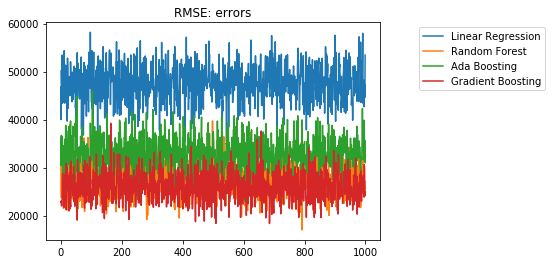

In [6]:
# airport_data = get_airport_data('SBFZ')

num_tests = 1000

RMSE_lr  = pax_and_seats_training('SBFZ', 0.25, num_tests, algorithm = linear_model.LinearRegression)
RMSE_rf  = pax_and_seats_training('SBFZ', 0.25, num_tests, algorithm = RandomForestRegressor)
RMSE_ada = pax_and_seats_training('SBFZ', 0.25, num_tests, algorithm = AdaBoostRegressor)
RMSE_gb  = pax_and_seats_training('SBFZ', 0.25, num_tests, algorithm = GradientBoostingRegressor)

RMSE_data = pd.DataFrame(data={ 'Linear Regression': RMSE_lr, 'Random Forest': RMSE_rf, 'Ada Boosting': RMSE_ada, 'Gradient Boosting': RMSE_gb})

ax = RMSE_data.plot(title='RMSE: errors')
ax.get_legend().set_bbox_to_anchor((1.1, 1))

RMSE_data.mean() # AVERAGE DOS ERROS DE CADA ALGORITMO.